In [1]:
import time, sys
from IPython.display import clear_output

def update_progress(progress, info=''):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100) + '\n' + info
    print(text)

In [2]:
from mnist import MNIST
import numpy as np
from scipy.spatial.distance import cdist
import cv2
import math
#https://pypi.org/project/python-mnist
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
mndata = MNIST('./python-mnist/data')
images_all, labels_all = mndata.load_training()

In [4]:
#chosing digit
digit = 8
images_all = np.array(images_all)
labels = np.array(labels_all)
images = images_all[labels==digit]

In [5]:
#chosing number of images
M = 10

In [6]:
import random
randoms = random.sample(range(0, len(images)), M)

In [7]:
weights = 1/M * np.ones(M, np.float64)
#weights = np.array(random.sample(range(1, 100), M), np.float64)
#weights /= weights.sum()
p = np.float64(images[:M])
p+=1e-6
p = p / p.sum(axis=1)[:,np.newaxis]

In [8]:
n = len(p[0]) #pixels number
m = int(np.sqrt(n)) #side pixels number

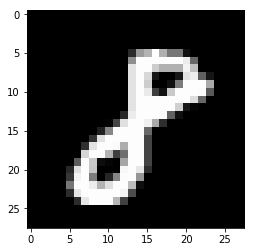

In [9]:
plot = True
if plot:
    plt.imshow(p[1].reshape(-1, m), cmap=plt.get_cmap('gray'))
    plt.show()

In [10]:
def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

C = np.arange(m)
C = cartesian_product(C, C)
C = cdist(C, C)
C[C==0] = 1e-1
C /= np.median(C)
C.max()

2.666869910953892

In [14]:
def f_(X):
    return np.einsum('k,kij,ij->', weights, X, C)

def f_true_(X):
    Y = X
    Y[X==0] = 1.
    return np.einsum('k,kij,ij->', weights, X, C) + gamma*np.einsum('k,kij,kij', weights, X, np.log(Y))

def phi_(u, v):
    return np.einsum('k,k', weights, (np.einsum('ki,ij,kj->k', np.exp(u),K,np.exp(v)) - np.einsum('ki,ki->k', u, p)))

def grad_phi_u_(u, v):
    return np.einsum('k,ki,ij,kj->ki', weights, np.exp(u),K,np.exp(v)) - np.einsum('k,ki->ki',weights, p)

def grad_phi_v_(u, v):
    v_M = -np.einsum('k,ki->i', weights[:M-1], v[:M-1]) / weights[-1]
    return np.einsum('k,ki,ij,kj->kj', weights[:M-1], np.exp(u[:M-1]),K,np.exp(v[:M-1])) - np.einsum('k,i,ij,j->kj', weights[:M-1], np.exp(u[-1]),K,np.exp(v_M))/weights[-1]

def argmin_u_(v):
    return np.log(p) - np.log(np.einsum('ij,kj->ki', K, np.exp(v)))

def argmin_v_(u):
    return np.einsum('k,ki->i', weights, np.log(np.einsum('ij,ki->kj', K, np.exp(u)))) - np.log(np.einsum('ij,ki->kj', K, np.exp(u)))    

# IBP

In [17]:
def IBP(N):
    primal=np.zeros([M, n, n], np.float64)
    phis=[]
    fs=[]
    fts=[]
    i=0
    v = np.zeros([M,n], np.float64)
    u = np.zeros([M,n], np.float64)
    while i < N:
        update_progress(i / N)
        if i%2 == 1:
            v = np.einsum('k,ki->i', weights, np.log(np.einsum('ij,ki->kj', K, np.exp(u)))) - np.log(np.einsum('ij,ki->kj', K, np.exp(u)))
        else:
            u = np.log(p) - np.log(np.einsum('ij,kj->ki', K, np.exp(v)))
        phis.append(phi_(u, v))
        i+=1
        primal = np.einsum('ki,ij,kj->kij',np.exp(u),K,np.exp(v))
        fs.append(f_(primal))
        fts.append(f_true_(primal))
    B = np.einsum('ki,ij,kj->kij',np.exp(u),K,np.exp(v))
    return N, phis, B, fs, fts

In [38]:
N=100
gamma=5e-3
K = np.exp(-C/gamma)
N1, phis1, B1, fs1, fts1 = IBP(N)

Progress: [####################] 99.0%



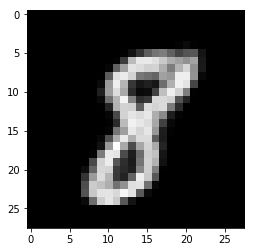

In [39]:
q_bar = np.einsum('k,kij->j', weights, B1)
plt.imshow(q_bar.reshape(-1, m), cmap=plt.get_cmap('gray'))
plt.show()

# ACCELERATED ALTERNATING MINIMIZATION

In [21]:
def AAM(N, L, step=2):
    primal=np.zeros([M, n, n], np.float64)
    xi = np.zeros([2*M, n], np.float64)
    eta = xi.copy()
    zeta = xi.copy()
    eta_new = xi.copy()
    zeta_new = xi.copy()
    grad2 = alpha_new = alpha = 0
    i=0
    phis=[]
    fs=[]
    fts=[]
    primal = np.einsum('ki,ij,kj->kij',np.exp(xi[M:]),K,np.exp(xi[:M]))
    while i < N:
        L_new = L/step
        while True:
            update_progress(i / N, '\tL='+str(L))
            alpha_new = 1/2/L_new + np.sqrt(1/4/L_new/L_new + alpha*alpha*L/L_new)
            tau = 1/alpha_new/L_new
            xi = tau*zeta + (1-tau)*eta
            grad_phi_v = grad_phi_v_(xi[M:], xi[:M])
            grad_phi_u = grad_phi_u_(xi[M:], xi[:M])
            if i%2 == 1:
                eta_new[:M] = argmin_v_(xi[M:])
            else:
                eta_new[M:] = argmin_u_(xi[:M])
            grad2 = (grad_phi_u*grad_phi_u).sum() + (grad_phi_v*grad_phi_v).sum()
            if phi_(eta_new[M:], eta_new[:M]) <= phi_(xi[M:], xi[:M]) - (grad2)/2/L_new:
                zeta_new[:M-1] = zeta_new[:M-1] - alpha_new * grad_phi_v
                zeta_new[M] = -np.einsum('k,ki->i', weights[:M-1], zeta_new[:M-1])/weights[-1]
                zeta_new[M:] = zeta_new[M:] - alpha_new * grad_phi_u
                phis.append(phi_(eta_new[M:], eta_new[:M]))
                primal=(alpha_new*np.einsum('ki,ij,kj->kij',np.exp(xi[M:]),K,np.exp(xi[:M]))+L*alpha*alpha*primal)/L_new/alpha_new/alpha_new
                fs.append(f_(primal))
                fts.append(f_true_(primal))
                alpha = alpha_new
                eta = eta_new.copy()
                zeta = zeta_new.copy()
                L = L_new
                break
            L_new*=step
        i+=1 
               
    B = np.einsum('ki,ij,kj->kij',np.exp(eta[M:]),K,np.exp(eta[:M]))        
    return N, np.array(phis), B, fs, fts

In [23]:
N=100
gamma = 5e-3
N2, phis2, B2, fs2, fts2 = AAM(N, 1, step=2)

Progress: [####################] 99.0%
	L=0.00390625


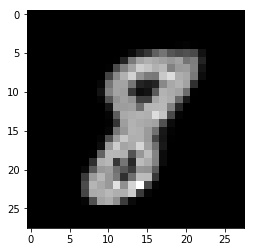

In [24]:
q_bar = np.einsum('k,kij->j', weights, B2)
plt.imshow(q_bar.reshape(-1, m), cmap=plt.get_cmap('gray'))
plt.show()

# ACCELERATED ALTERNATING MINIMIZATION (LINE SEARCH)

In [25]:
def binary_ab(f, xleft, xright, eps_search):
    N = math.floor(np.log2(abs(xright - xleft)/eps_search)) + 1
    k=0
    a = xleft + (xright - xleft)/4
    b = xleft + (xright - xleft)/2
    fa = f(a)
    fb = f(b)
    fleft = f(xleft)
    fright = f(xright)
    while fb - fa > eps_search or k < N:
        #print(fa, fb)
        if fa > fb:
            fleft = fa
            xleft = a
        elif fb > fa:
            fright = fb
            xright = b
        else:
            break
        k+=1
    
        a = xleft + (xright - xleft)/4
        b = xleft + (xright - xleft)/2
        fa = f(a)
        fb = f(b)
        
    #return xleft, fleft
    
    minf = min(fleft, fa, fb, fright)
    if minf == fleft:
        return xleft, fleft
    elif minf == fa:
        return a, fa
    elif minf == fb:
        return b, fb
    elif minf == fright:
        return xright, fright
    
def phi_1d_(x, e):
    def phi_1d(h):
        vu = x + e*h
        return phi_(vu[M:], vu[:M])
    return phi_1d

In [33]:
def AAM_line_search(N):
    primal=np.zeros([M, n, n], np.float64)
    xi = np.zeros([2*M, n], np.float64)
    eta = xi.copy()
    zeta = xi.copy()
    grad_phi_u = np.zeros([M, n], np.float64)
    grad_phi_v = np.zeros([M, n], np.float64)
    alpha = 0
    i=0
    A=0
    phis=[]
    fs=[]
    fts=[]
    primal = np.einsum('ki,ij,kj->kij',np.exp(xi[M:]),K,np.exp(xi[:M]))
    while i < N:
        update_progress(i / N)
        beta, _ = binary_ab(phi_1d_(eta, (zeta-eta)), 0, 1, 1e-4)
        xi = eta + beta*(zeta - eta)
        
        grad_phi_v = grad_phi_v_(xi[M:], xi[:M])
        grad_phi_u = grad_phi_u_(xi[M:], xi[:M])
        if i%2 == 0:
            eta[:M] = argmin_v_(xi[M:])
        else:
            eta[M:] = argmin_u_(xi[:M])
            
        a = (grad_phi_u*grad_phi_u).sum() + (grad_phi_v*grad_phi_v).sum()
        b = 2*(phi_(eta[M:], eta[:M]) - phi_(xi[M:], xi[:M]))
        c = b*A
         
        alpha = (-b + np.sqrt(b*b - 4*a*c))/2/a
        A+=alpha
        
        zeta[M:] = zeta[M:] - alpha * grad_phi_u        
        zeta[:M-1] = zeta[:M-1] - alpha * grad_phi_v
        zeta[M] = -np.einsum('k,ki->i', weights[:M-1], zeta[:M-1])/weights[-1]
        
        phis.append(phi_(xi[M:], xi[:M]))
        primal=np.einsum('ki,ij,kj->kij',np.exp(xi[M:]),K,np.exp(xi[:M]))
        fs.append(f_(primal))
        fts.append(f_true_(primal))
        i+=1
        
    B = np.einsum('ki,ij,kj->kij',np.exp(eta[M:]),K,np.exp(eta[:M]))        
    return N, np.array(phis), B, fs, fts

In [41]:
N=100
gamma = 5e-3
N3, phis3, B3, fs3, fts3 = sea_IBP(N)

Progress: [####################] 99.0%



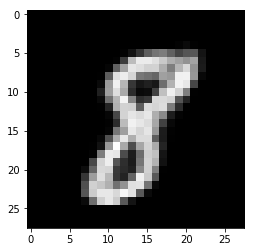

In [30]:
q_bar = np.einsum('k,kij->j', weights, B3)
plt.imshow(q_bar.reshape(-1, m), cmap=plt.get_cmap('gray'))
plt.show()

# COMPARISON

In [48]:
N = min(N1, N2, N3)
begin = 10
x = range(begin, N)

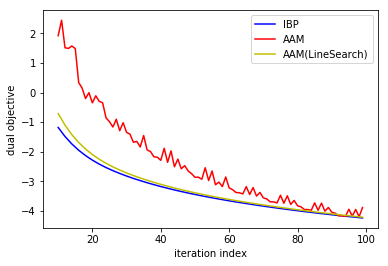

In [49]:
fig, ax = plt.subplots()
ax.plot(x, phis1[begin:N], '-b', label='IBP')
ax.plot(x, phis2[begin:N], '-r', label='AAM')
ax.plot(x, phis3[begin:N], '-y', label='AAM(LineSearch)')
ax.set_xlabel('iteration index')
ax.set_ylabel('dual objective')
leg = ax.legend();

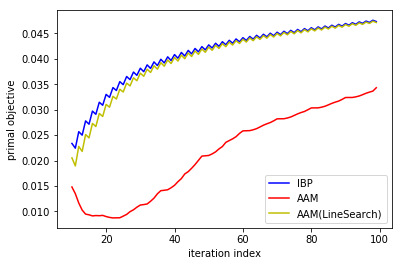

In [50]:
fig, ax = plt.subplots()
ax.plot(x, fs1[begin:N], '-b', label='IBP')
ax.plot(x, fs2[begin:N], '-r', label='AAM')
ax.plot(x, fs3[begin:N], '-y', label='AAM(LineSearch)')
ax.set_xlabel('iteration index')
ax.set_ylabel('primal objective')
leg = ax.legend();

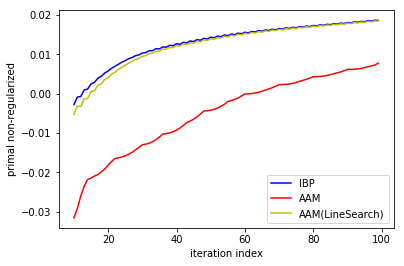

In [51]:
fig, ax = plt.subplots()
ax.plot(x, fts1[begin:N], '-b', label='IBP')
ax.plot(x, fts2[begin:N], '-r', label='AAM')
ax.plot(x, fts3[begin:N], '-y', label='AAM(LineSearch)')
ax.set_xlabel('iteration index')
ax.set_ylabel('primal non-regularized')
leg = ax.legend();